In [ ]:
import os
from PIL import Image
import numpy as np
import json
import random
import torch

In [ ]:
class ARC_Task:
  def __init__(self, inputs, outputs, test_input, test_output):
    self.inputs = inputs
    self.outputs = outputs
    self.test_input = test_input
    self.test_output = test_output

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

def visualize(tensor):
  #torch.argmax(tensor.reshape(30, 30, 11)).item()
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  convert(arr)

def visualize2(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      difs = [torch.abs(v - tensor[x, y]) for v in color2vector]
      sums = [torch.sum(difs[i]) for i in range(11)]
      index_min = min(range(len(sums)), key=sums.__getitem__)
      #print(index_min)
      arr[x, y] = index_min
  convert(arr)

converter = {}
converter[0] = np.array([0, 0, 0])
converter[1] = np.array([0, 116, 217])
converter[2] = np.array([255, 65, 54])
converter[3] = np.array([46, 204, 64])
converter[4] = np.array([255, 220, 0])
converter[5] = np.array([170, 170, 170])
converter[6] = np.array([240, 18, 190])
converter[7] = np.array([255, 113, 27])
converter[8] = np.array([127, 219, 255])
converter[9] = np.array([135, 12, 37])
converter[10] = np.array([255, 255, 255])

def convert(X):
  Y = np.zeros(shape=(X.shape[0], X.shape[1], 3), dtype=np.uint8)
  for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      Y[x, y] = converter[X[x, y]]
  imshow(Y)

In [ ]:
def fetch():
  data = []
  MAX_LENGTH = 30
  files = [f for f in os.listdir() if f.endswith('json')]
  for f in files:
    with open(f, 'r') as file:
      json_file = json.loads(file.read())
      inputs = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['train']]
      outputs = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['train']]
      test_input = [one_hot_encode(np.array(train_exmaples['input'])) for train_exmaples in json_file['test']]
      test_output = [one_hot_encode(np.array(train_exmaples['output'])) for train_exmaples in json_file['test']]
      data.append(ARC_Task(inputs, outputs, test_input[0], test_output[0]))

  return data

def one_hot_encode(array):
  MAX_LENGTH = 30
  arr = torch.zeros((MAX_LENGTH, MAX_LENGTH, 11))
  size = array.shape
  for x in range(MAX_LENGTH):
    for y in range(MAX_LENGTH):
      if x < size[0] and y < size[1]:
        arr[x, y, array[x, y]] = 1
      else:
        arr[x, y, 10] = 1
  return arr.flatten()

In [ ]:
from torch.utils.data import Dataset

class ARCDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    return self.data[idx]

  def __len__(self):
    return len(self.data)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):

  def __init__(self, input_shape=30*30*11, latent_dim = 128):
    super().__init__()
    self.input_shape = input_shape
    self.latent_dim = latent_dim
    self.encoder_l1 = nn.Linear(self.input_shape, self.latent_dim, bias=True)
    self.drop1 = nn.Dropout(0.5)
    self.encoder_l2 = nn.Linear(self.latent_dim, self.latent_dim, bias=True)
    self.decoder_l1 = nn.Linear(self.latent_dim, self.latent_dim, bias=True)
    self.drop2 = nn.Dropout(0.5)
    self.decoder_l2 = nn.Linear(self.latent_dim, self.input_shape, bias=True)

  def forward(self, task):
    task_vector = torch.zeros(self.latent_dim)
    for input, output in zip(task.inputs, task.outputs):
      latent_input = model.run_encoder(input)
      latent_output = model.run_encoder(output)
      task_vector += latent_output - latent_input
    task_vector /= len(task.inputs)
    latent_prediction = model.run_encoder(task.test_input) + task_vector
    prediction = model.run_decoder(latent_prediction)
    return prediction

  def run_encoder(self, x):
    output = self.drop1(F.sigmoid(self.encoder_l1(x)))
    latent = F.sigmoid(self.encoder_l2(output))
    return latent

  def run_decoder(self, latent):
    output = self.drop2(F.sigmoid(self.decoder_l1(latent)))
    x_hat = F.sigmoid(self.decoder_l2(output))
    return x_hat

In [ ]:
train_dataset = ARCDataset(fetch())
len(train_dataset)

400

In [ ]:
model = Autoencoder(latent_dim=400)
model.train()

Autoencoder(
  (encoder_l1): Linear(in_features=9900, out_features=400, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (encoder_l2): Linear(in_features=400, out_features=400, bias=True)
  (decoder_l1): Linear(in_features=400, out_features=400, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (decoder_l2): Linear(in_features=400, out_features=9900, bias=True)
)

In [ ]:
import torch.optim as optim

mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 30

for epoch in range(n_epochs):
  loss = 0

  for task in train_dataset:
    #task = task.cuda()
    optimizer.zero_grad()
    prediction = model(task)
    train_loss = mse(prediction, task.test_output)
    train_loss.backward()
    optimizer.step()
    loss += train_loss.item()

  if epoch % 5 == 0:
    print(epoch, loss)

0 4.913577297586016
5 4.779691016417928
10 4.685127571108751
15 4.649243375228252
20 4.501520568388514
25 4.4617546204826795


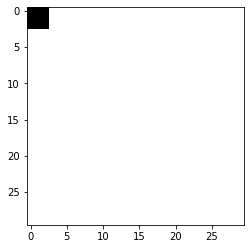

In [ ]:
p = model.forward(train_dataset[145])
visualize(p.reshape(30, 30, 11))